In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import googlemaps
import requests
import json
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
def load_api(path="confidential.json"):
	with open(path) as f:
		data = json.load(f)
	return data.get("api_key", "API key not found")
	
api_key = load_api()

In [3]:
# zip_tract = pd.read_excel("D:\Download\HVIprediction\ZIP_TRACT_122024.xlsx")
# zip_tract = zip_tract[zip_tract['USPS_ZIP_PREF_STATE'] == 'NJ']
# zip_tract.to_csv("D:\Download\HVIprediction\ZIP_TRACT_122024_NJ.csv", index=False)

In [4]:
zip_tract = pd.read_csv("D:\Download\HVIprediction\data\ZIP_TRACT_122024_NJ.csv")
# zip_tract = zip_tract.sort_values(by=['TRACT', 'RES_RATIO'], ascending=[True, False])
# zip_tract = zip_tract.drop_duplicates(subset='TRACT', keep='first')
# zip_tract = zip_tract[['TRACT', 'ZIP']]
# zip_tract = zip_tract.rename(columns={'TRACT': 'GEOID', 'ZIP': 'ZCTA'})
zip_tract.to_csv("D:\Download\HVIprediction\data\ZIP_TRACT_122024_NJ.csv", index=False)

In [5]:
nj_hvi = pd.read_csv('data/nj_hvi.csv')

In [6]:
nj_hvi = nj_hvi.merge(zip_tract, on=['GEOID', 'ZCTA'], how='inner')
nj_hvi.head()

,Adaptive_Capacity_Scale,Annual_PM25_Concentration,Asthma_Prevalence,CoronaryHeartDisease_Prevalence,COUNTYFP,Diabetes_Prevalence,Exposure_Scale,GEOID,HVI_Category,HVI_Scale,Impervious_to_Canopy_Ratio,NAME,NAMELSAD,O3_Exceedance_Days,ObjectID,Percent_Below_PovertyLine,Percent_Linguistic_Isolation,Percent_NoHealth+V1Insurance,Percent_Aged_Above_65,Percent_Aged_Below_5,Percent_with_Disability,Percent_Homes_Built_before_1960,Percent_in_Outdoor_Occupations,Percent_Living_Alone,Percent_NonWhite,Percent_Unemployed,Percent_without_HighSchoolDiploma,Sensitivity_Scale,STATEFP,Tract_Summ,TRACTCE,Shape__Area,Shape__Length,OBJECTID_1,ZCTA,Lat,Lon
0,1,2,3,1,31,1,1,34031256804,Low,1,1,2568.04,Census Tract 2568.04,2,1396,1,1,3,3,2,2,2,2,1,1,2,1,1,34,1,256804,"53,904,326.71","39,088.52",1,7480,41.098546,-74.393934
1,4,2,3,3,31,2,1,34031246300,Moderate,3,2,2463.00,Census Tract 2463,2,1836,4,3,4,2,3,2,3,4,3,3,4,3,3,34,1,246300,"18,543,764.50","32,287.12",2,7470,40.941149,-74.253146
2,5,2,5,3,31,5,3,34031181200,Moderate_High,4,5,1812.00,Census Tract 1812,2,1743,5,5,5,1,5,1,4,5,1,5,4,5,4,34,3,181200,"704,177.54","3,557.55",3,7514,40.923473,-74.144549
3,2,2,3,5,31,3,1,34031256803,Low,1,1,2568.03,Census Tract 2568.03,2,1402,2,2,3,5,4,1,2,3,5,2,1,2,3,34,1,256803,"26,408,937.79","30,301.58",4,7480,41.098546,-74.393934
4,1,2,2,3,31,2,1,34031246003,Low,1,2,2460.03,Census Tract 2460.03,2,1395,1,3,1,4,5,2,3,2,1,2,2,2,2,34,1,246003,"14,709,914.19","20,129.26",5,7470,40.941149,-74.253146


In [7]:
gmaps = googlemaps.Client(key=api_key)
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

def location_retrieve(zipcode, state):
    """Retrieve latitude and longitude for a given ZIP code with caching to reduce API calls."""    
    endpoint = f"{base_url}?components=country=us&address={zipcode},{state}&key={api_key}"
    response = requests.get(endpoint).json()
    if 'results' in response and response['results']:
        return response['results'][0]['geometry']['location']['lat'], response['results'][0]['geometry']['location']['lng']
    return None, None

In [8]:
# nj_hvi["ZCTA"] = nj_hvi["ZCTA"].astype(str).str.zfill(5)

# latitudes, longitudes = [], []
# for zipcode in tqdm(nj_hvi["ZCTA"], desc="Fetching geolocation data"):
#     lat, lon = location_retrieve(zipcode, "NJ")
#     latitudes.append(lat)
#     longitudes.append(lon)

# # Assign results to DataFrame
# nj_hvi["Lat"] = latitudes
# nj_hvi["Lon"] = longitudes

In [9]:
nj_hvi.head()


,Adaptive_Capacity_Scale,Annual_PM25_Concentration,Asthma_Prevalence,CoronaryHeartDisease_Prevalence,COUNTYFP,Diabetes_Prevalence,Exposure_Scale,GEOID,HVI_Category,HVI_Scale,Impervious_to_Canopy_Ratio,NAME,NAMELSAD,O3_Exceedance_Days,ObjectID,Percent_Below_PovertyLine,Percent_Linguistic_Isolation,Percent_NoHealth+V1Insurance,Percent_Aged_Above_65,Percent_Aged_Below_5,Percent_with_Disability,Percent_Homes_Built_before_1960,Percent_in_Outdoor_Occupations,Percent_Living_Alone,Percent_NonWhite,Percent_Unemployed,Percent_without_HighSchoolDiploma,Sensitivity_Scale,STATEFP,Tract_Summ,TRACTCE,Shape__Area,Shape__Length,OBJECTID_1,ZCTA,Lat,Lon
0,1,2,3,1,31,1,1,34031256804,Low,1,1,2568.04,Census Tract 2568.04,2,1396,1,1,3,3,2,2,2,2,1,1,2,1,1,34,1,256804,"53,904,326.71","39,088.52",1,7480,41.098546,-74.393934
1,4,2,3,3,31,2,1,34031246300,Moderate,3,2,2463.00,Census Tract 2463,2,1836,4,3,4,2,3,2,3,4,3,3,4,3,3,34,1,246300,"18,543,764.50","32,287.12",2,7470,40.941149,-74.253146
2,5,2,5,3,31,5,3,34031181200,Moderate_High,4,5,1812.00,Census Tract 1812,2,1743,5,5,5,1,5,1,4,5,1,5,4,5,4,34,3,181200,"704,177.54","3,557.55",3,7514,40.923473,-74.144549
3,2,2,3,5,31,3,1,34031256803,Low,1,1,2568.03,Census Tract 2568.03,2,1402,2,2,3,5,4,1,2,3,5,2,1,2,3,34,1,256803,"26,408,937.79","30,301.58",4,7480,41.098546,-74.393934
4,1,2,2,3,31,2,1,34031246003,Low,1,2,2460.03,Census Tract 2460.03,2,1395,1,3,1,4,5,2,3,2,1,2,2,2,2,34,1,246003,"14,709,914.19","20,129.26",5,7470,40.941149,-74.253146


In [10]:
print(nj_hvi.shape)
nj_hvi.columns

(1818, 37)


Index(['Adaptive_Capacity_Scale', 'Annual_PM25_Concentration',
       'Asthma_Prevalence', 'CoronaryHeartDisease_Prevalence', 'COUNTYFP',
       'Diabetes_Prevalence', 'Exposure_Scale', 'GEOID', 'HVI_Category',
       'HVI_Scale', 'Impervious_to_Canopy_Ratio', 'NAME', 'NAMELSAD',
       'O3_Exceedance_Days', 'ObjectID', 'Percent_Below_PovertyLine',
       'Percent_Linguistic_Isolation', 'Percent_NoHealth+V1Insurance',
       'Percent_Aged_Above_65', 'Percent_Aged_Below_5',
       'Percent_with_Disability', 'Percent_Homes_Built_before_1960',
       'Percent_in_Outdoor_Occupations', 'Percent_Living_Alone',
       'Percent_NonWhite', 'Percent_Unemployed',
       'Percent_without_HighSchoolDiploma', 'Sensitivity_Scale', 'STATEFP',
       'Tract_Summ', 'TRACTCE', 'Shape__Area', 'Shape__Length', 'OBJECTID_1',
       'ZCTA', 'Lat', 'Lon'],
      dtype='object')

In [11]:
nj_hvi_num = nj_hvi.select_dtypes(include=['float64', 'int64']).drop(columns=['GEOID', 'ZCTA', 'COUNTYFP','NAME', 'ObjectID', 'STATEFP', 'Tract_Summ',	'TRACTCE', 'OBJECTID_1'])
nj_hvi_num = nj_hvi_num.replace(-999, np.nan)
nj_hvi_num = nj_hvi_num.dropna()
print(nj_hvi_num.shape)
nj_hvi_num

(1818, 24)


,Adaptive_Capacity_Scale,Annual_PM25_Concentration,Asthma_Prevalence,CoronaryHeartDisease_Prevalence,Diabetes_Prevalence,Exposure_Scale,HVI_Scale,Impervious_to_Canopy_Ratio,O3_Exceedance_Days,Percent_Below_PovertyLine,Percent_Linguistic_Isolation,Percent_NoHealth+V1Insurance,Percent_Aged_Above_65,Percent_Aged_Below_5,Percent_with_Disability,Percent_Homes_Built_before_1960,Percent_in_Outdoor_Occupations,Percent_Living_Alone,Percent_NonWhite,Percent_Unemployed,Percent_without_HighSchoolDiploma,Sensitivity_Scale,Lat,Lon
0,1,2,3,1,1,1,1,1,2,1,1,3,3,2,2,2,2,1,1,2,1,1,41.098546,-74.393934
1,4,2,3,3,2,1,3,2,2,4,3,4,2,3,2,3,4,3,3,4,3,3,40.941149,-74.253146
2,5,2,5,3,5,3,4,5,2,5,5,5,1,5,1,4,5,1,5,4,5,4,40.923473,-74.144549
3,2,2,3,5,3,1,1,1,2,2,2,3,5,4,1,2,3,5,2,1,2,3,41.098546,-74.393934
4,1,2,2,3,2,1,1,2,2,1,3,1,4,5,2,3,2,1,2,2,2,2,40.941149,-74.253146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,4,1,4,2,2,2,3,3,3,4,4,2,2,4,5,2,4,3,2,4,4,3,40.050898,-74.135741
1814,2,1,3,5,5,2,3,3,3,4,2,1,5,1,3,1,4,5,1,3,3,5,40.050898,-74.135741
1815,2,5,4,4,3,5,3,3,5,1,1,3,4,1,3,4,4,4,1,4,2,3,39.952443,-74.996854
1816,1,5,2,4,2,4,3,2,5,1,1,2,5,1,2,5,1,3,1,3,2,2,39.979090,-74.932568


In [12]:
nj_hvi_num = nj_hvi_num.rename(columns={'HVI_Scale': 'HVI',
                                        'Adaptive_Capacity_Scale': 'Adaptive',
                                        'Annual_PM25_Concentration': 'P_PM25',
                                        'Sensitivity_Scale': "Sensitivity",
                                        'Exposure_Scale': 'Exposure',
                                        'Impervious_to_Canopy_Ratio': "ICR",
                                        'Asthma_Prevalence': 'P_ASTHMA',
										'CoronaryHeartDisease_Prevalence': 'P_COPD',
										'Diabetes_Prevalence': 'P_DIABETES',
										'O3_Exceedance_Days': 'P_OZONE',
										'Percent_Below_PovertyLine': 'P_POV',
										'Percent_Linguistic_Isolation': 'P_ELP',
										'Percent_NoHealth+V1Insurance': 'P_UNINSUR',
										'Percent_Aged_Above_65': 'P_AGE65',
										'Percent_Aged_Below_5': 'P_AGE5',
										'Percent_with_Disability': 'P_DISABL',
										'Percent_Living_Alone': 'P_ISO',
										'Percent_Unemployed': 'P_UNEMP',
										'Percent_without_HighSchoolDiploma': 'P_NOHSDP',
                                        'Percent_Homes_Built_before_1960': 'P_OLDHOME',	
                                        'Percent_in_Outdoor_Occupations': 'P_OUTDOOR',
                                        'Percent_NonWhite': 'P_NONWHITE'})

#### Merge data for semi-supervised ordinal classification

In [13]:
# hhi_data = pd.read_excel(rf"D:\Download\HVIprediction\data\HHI Data 2024 United States.xlsx")
# hhi_nj_fl_ca = hhi_data[hhi_data['STATE'].isin(['NJ', 'FL', 'CA'])]
# hhi_nj_fl_ca.to_csv(rf"D:\Download\HVIprediction\data\hhi_nj_fl_ca.csv", index=False)

hhi_nj_fl_ca = pd.read_csv(rf"D:\Download\HVIprediction\data\hhi_nj_fl_ca.csv")

In [14]:
# hhi_nj_fl_ca["ZCTA"] = hhi_nj_fl_ca["ZCTA"].astype(str).str.zfill(5)

# # Apply function efficiently while reducing API calls
# latitudes, longitudes = [], []
# for zipcode in tqdm(hhi_nj_fl_ca["ZCTA"], desc="Fetching geolocation data"):
#     lat, lon = location_retrieve(zipcode, hhi_nj_fl_ca[hhi_nj_fl_ca["ZCTA"] == zipcode]["STATE"].iloc[0])
#     latitudes.append(lat)
#     longitudes.append(lon)

# # Assign results to DataFrame
# hhi_nj_fl_ca["Lat"] = latitudes
# hhi_nj_fl_ca["Lon"] = longitudes

In [15]:
hhi_nj_fl_ca_num = hhi_nj_fl_ca.select_dtypes(include=['float64', 'int64']).drop(columns=['GEOID10', 'ZCTA','MULTI_STATE'])
hhi_nj_fl_ca_num.head()

,STATEFP10,POP,PR_HRI,F_HRI,LOW_EMS,P_NEHD,PR_NEHD,HHB_SCORE,HHB_RANK,P_CHD,PR_CHD,F_CHD,P_OBS,PR_OBS,F_OBS,P_DIABETES,PR_DIABETES,F_DIABETES,P_COPD,PR_COPD,F_COPD,P_ASTHMA,PR_ASTHMA,F_ASTHMA,P_MNTHL,PR_MNTHL,F_MNTHL,F_SEN_COUNT,SEN_SCORE,SEN_RANK,P_UNINSUR,PR_UNINSUR,P_POV,PR_POV,P_UNEMP,PR_UNEMP,P_NOHSDP,PR_NOHSDP,P_ISO,PR_ISO,P_ELP,PR_ELP,P_DISABL,PR_DISABL,P_ODW,PR_ODW,P_AGE65,PR_AGE65,P_AGE5,PR_AGE5,SOCIODEM_SCORE,SOCIODEM_RANK,P_IMPERV,PR_IMPERV,P_TREEC,PR_TREEC,P_NOVEH,PR_NOVEH,P_MOBILE,PR_MOBILE,P_RENT,PR_RENT,P_OZONE,PR_OZONE,P_PM25,PR_PM25,NBE_SCORE,NBE_RANK,OVERALL_SCORE,OVERALL_RANK,Lat,Lon
0,34,16305,20,0.25,0,9.200000,0.2370,0.2435,0.0426,4.8,0.1385,0,33.2,0.2737,0,10.6,0.4152,0,5.3,0.1363,0,9.0,0.0960,0,15.0,0.3345,0,0,0.0,0.0,7.3,0.5419,16.990921,0.3764,5.4,0.6279,7.7,0.3786,12.967654,0.4520,4.517345,0.8833,9.3,0.1788,6.286484,0.2090,10.9,0.1255,5.6,0.5283,0.4302,0.3412,54.412326,0.9511,15.580474,0.6075,5.9,0.6549,7.5,0.5108,49.601752,0.9043,1.666667,0.8026,0.000000,0.0000,0.6330,0.8795,0.3158,0.2049,40.582712,-74.270751
1,34,63031,53,0.75,0,11.214286,0.3736,0.5618,0.5226,5.6,0.2682,0,25.8,0.0557,0,10.3,0.3721,0,6.1,0.2280,0,9.8,0.2874,0,14.9,0.3220,0,0,0.0,0.0,9.8,0.6824,23.700924,0.5849,6.0,0.6889,11.4,0.5775,15.901331,0.6560,7.182714,0.9285,10.6,0.2589,6.609622,0.2251,14.2,0.2691,7.2,0.7801,0.5651,0.6847,72.711006,0.9873,3.474450,0.8253,23.2,0.9683,0.4,0.1847,61.533224,0.9521,1.666667,0.8026,0.000000,0.0000,0.6743,0.9223,0.5324,0.6269,40.658801,-74.106378
2,34,47312,55,0.75,0,11.153846,0.3645,0.5572,0.5127,4.5,0.1016,0,27.9,0.0939,0,8.7,0.1649,0,4.8,0.0893,0,9.3,0.1494,0,13.2,0.1217,0,0,0.0,0.0,8.8,0.6323,15.112355,0.3161,6.7,0.7454,8.1,0.4029,15.531732,0.6321,5.205557,0.8986,9.2,0.1743,7.010208,0.2469,13.4,0.2272,6.3,0.6495,0.4925,0.4971,47.868887,0.9307,21.711265,0.5284,9.3,0.8279,0.0,0.0000,48.516983,0.8989,1.666667,0.8026,0.333333,0.6092,0.6568,0.9052,0.4788,0.5217,40.798907,-74.188582
3,34,7440,20,0.25,1,11.800000,0.4164,0.3332,0.1305,5.6,0.2682,0,24.2,0.0331,0,7.8,0.0873,0,5.2,0.1262,0,8.6,0.0493,0,11.2,0.0195,0,0,0.0,0.0,2.6,0.1643,1.799729,0.0247,2.1,0.2157,6.1,0.2782,7.343670,0.1152,1.918977,0.7670,10.9,0.2787,4.943697,0.1458,27.9,0.8770,4.8,0.3895,0.3256,0.1304,22.259740,0.8187,45.347987,0.2883,4.3,0.5172,0.0,0.0000,8.927890,0.1061,1.333333,0.7627,0.333333,0.6092,0.4432,0.5060,0.1917,0.0516,40.884401,-74.305955
4,34,15269,50,0.50,0,12.625000,0.4868,0.4934,0.3699,5.1,0.1812,0,26.0,0.0589,0,8.5,0.1447,0,5.1,0.1156,0,8.9,0.0820,0,13.0,0.1061,0,0,0.0,0.0,4.4,0.3132,11.319473,0.2034,5.1,0.5944,5.3,0.2297,11.196106,0.3211,3.168692,0.8403,8.0,0.1116,4.525320,0.1306,15.4,0.3402,4.7,0.3746,0.3459,0.1630,5.812880,0.6749,60.942031,0.1402,5.0,0.5802,0.0,0.0000,26.926580,0.6033,1.000000,0.6973,0.333333,0.6092,0.4722,0.5837,0.2792,0.1474,40.924504,-74.417388


In [16]:
hhi_nj_fl_ca_num = hhi_nj_fl_ca_num.replace(-999, np.nan)
hhi_nj_fl_ca_num = hhi_nj_fl_ca_num.dropna()

In [17]:
hhi_nj_fl_ca_num["ICR"] = hhi_nj_fl_ca_num["P_IMPERV"] / hhi_nj_fl_ca_num["P_TREEC"]
hhi_nj_fl_ca_num.columns

Index(['STATEFP10', 'POP', 'PR_HRI', 'F_HRI', 'LOW_EMS', 'P_NEHD', 'PR_NEHD',
       'HHB_SCORE', 'HHB_RANK', 'P_CHD', 'PR_CHD', 'F_CHD', 'P_OBS', 'PR_OBS',
       'F_OBS', 'P_DIABETES', 'PR_DIABETES', 'F_DIABETES', 'P_COPD', 'PR_COPD',
       'F_COPD', 'P_ASTHMA', 'PR_ASTHMA', 'F_ASTHMA', 'P_MNTHL', 'PR_MNTHL',
       'F_MNTHL', 'F_SEN_COUNT', 'SEN_SCORE', 'SEN_RANK', 'P_UNINSUR',
       'PR_UNINSUR', 'P_POV', 'PR_POV', 'P_UNEMP', 'PR_UNEMP', 'P_NOHSDP',
       'PR_NOHSDP', 'P_ISO', 'PR_ISO', 'P_ELP', 'PR_ELP', 'P_DISABL',
       'PR_DISABL', 'P_ODW', 'PR_ODW', 'P_AGE65', 'PR_AGE65', 'P_AGE5',
       'PR_AGE5', 'SOCIODEM_SCORE', 'SOCIODEM_RANK', 'P_IMPERV', 'PR_IMPERV',
       'P_TREEC', 'PR_TREEC', 'P_NOVEH', 'PR_NOVEH', 'P_MOBILE', 'PR_MOBILE',
       'P_RENT', 'PR_RENT', 'P_OZONE', 'PR_OZONE', 'P_PM25', 'PR_PM25',
       'NBE_SCORE', 'NBE_RANK', 'OVERALL_SCORE', 'OVERALL_RANK', 'Lat', 'Lon',
       'ICR'],
      dtype='object')

In [18]:
pred_df = hhi_nj_fl_ca_num[['P_PM25', 'P_ASTHMA', 'P_COPD', 'P_DIABETES',
       'ICR', 'P_OZONE', 'P_POV', 'P_ELP', 'P_UNINSUR', 'P_AGE65',
       'P_AGE5', 'P_DISABL', 'P_ISO', 'P_UNEMP', 'P_NOHSDP']]
pred_df.head()

,P_PM25,P_ASTHMA,P_COPD,P_DIABETES,ICR,P_OZONE,P_POV,P_ELP,P_UNINSUR,P_AGE65,P_AGE5,P_DISABL,P_ISO,P_UNEMP,P_NOHSDP
0,0.000000,9.0,5.3,10.6,3.492341,1.666667,16.990921,4.517345,7.3,10.9,5.6,9.3,12.967654,5.4,7.7
1,0.000000,9.8,6.1,10.3,20.927346,1.666667,23.700924,7.182714,9.8,14.2,7.2,10.6,15.901331,6.0,11.4
2,0.333333,9.3,4.8,8.7,2.204795,1.666667,15.112355,5.205557,8.8,13.4,6.3,9.2,15.531732,6.7,8.1
3,0.333333,8.6,5.2,7.8,0.490865,1.333333,1.799729,1.918977,2.6,27.9,4.8,10.9,7.343670,2.1,6.1
4,0.333333,8.9,5.1,8.5,0.095384,1.000000,11.319473,3.168692,4.4,15.4,4.7,8.0,11.196106,5.1,5.3


##### Select data for unsupervised clustering

In [45]:
clustering_data = hhi_nj_fl_ca_num[['STATEFP10', 'POP', "HHB_SCORE", "SEN_SCORE", "SOCIODEM_SCORE", "NBE_SCORE"]]

### EDA

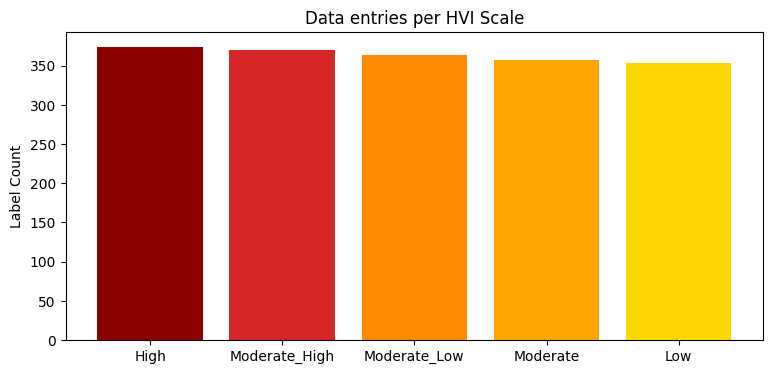

In [20]:
# plot HVI scale to see if data is imbalanced
# data is indeed balanced
hvi_scale = nj_hvi['HVI_Category'].value_counts().reset_index()
fig, ax = plt.subplots()

fig.set_size_inches(9, 4)
labels = hvi_scale['index']
counts = hvi_scale["HVI_Category"]
bar_colors = ['darkred', 'tab:red', 'darkorange', 'orange', 'gold']

ax.bar(labels, counts, color=bar_colors)

ax.set_ylabel('Label Count')
ax.set_title('Data entries per HVI Scale')

plt.show()

In [21]:
municipal_path = rf"D:\Download\HVIprediction\data\nj_municipal\NJ_Municipal_Boundaries_3424.shp"
census_path = rf"D:\Download\HVIprediction\data\nj_census\Census_Blocks_2020_(Govt_TIGER2020_blk20).shp"

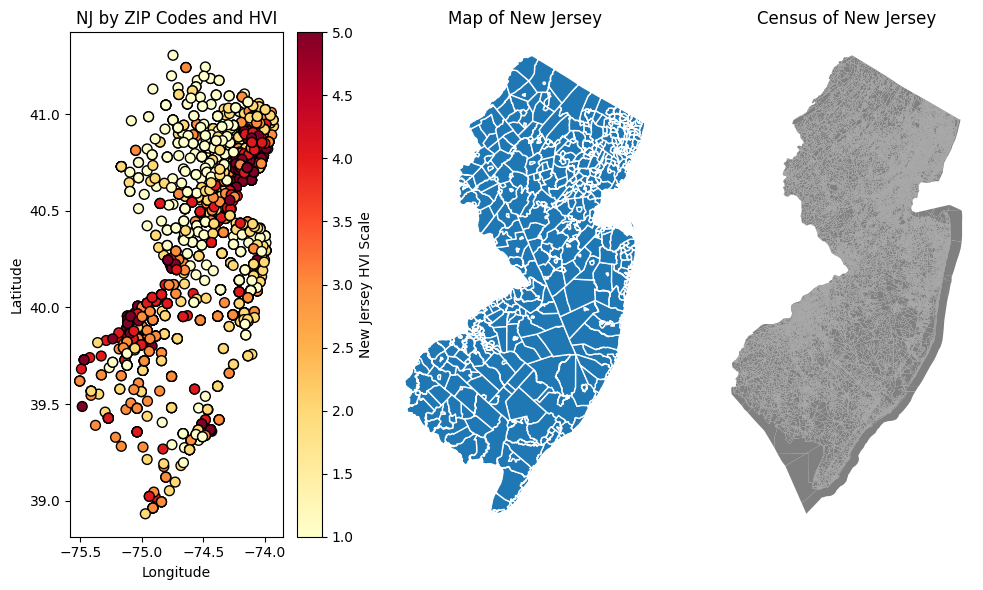

In [22]:
# Load the shapefile
nj = gpd.read_file(municipal_path)
nj_census = gpd.read_file(census_path)

# Create a figure with 2 subplots (side by side)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))

# --- First Subplot: HVI Scatter Plot ---
sc = ax1.scatter(nj_hvi_num['Lon'], nj_hvi_num['Lat'], 
                 c=nj_hvi_num['HVI'], cmap='YlOrRd', edgecolor='k', s=50)
cbar = fig.colorbar(sc, ax=ax1, label='New Jersey HVI Scale')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('NJ by ZIP Codes and HVI')

# --- Second Subplot: NJ Municipal Boundaries ---
nj.plot(ax=ax2, edgecolor='white')
nj_census.plot(ax=ax3, color='grey', alpha=1)

ax2.set_title("Map of New Jersey")
ax2.set_axis_off()  # Hide axis for better visualization
ax3.set_title("Census of New Jersey")
ax3.set_axis_off()  # Hide axis for better visualization

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with both plots
plt.show()


### Supervised ordinal classification with labelled HVI data

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, cohen_kappa_score

import krippendorff

##### Correlation matrix and PCA

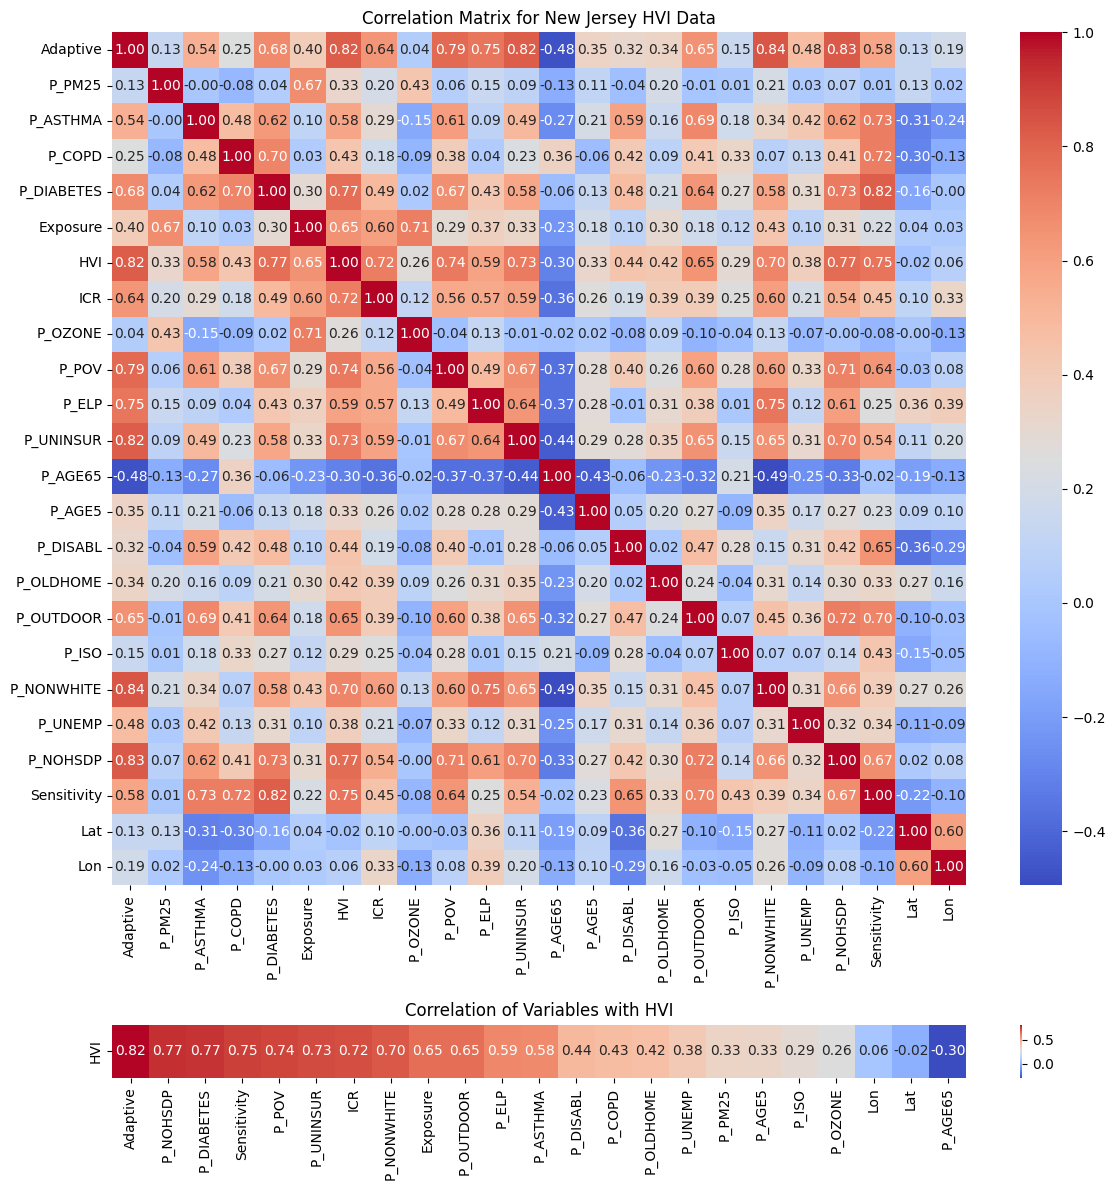

In [24]:
# Compute correlation matrix
corr_matrix = nj_hvi_num.corr()

# Extract correlation of all variables with HVI
hvi_corr = corr_matrix[['HVI']].sort_values(by='HVI', ascending=False)[1:].T

# Create figure with GridSpec to control subplot sizes
fig = plt.figure(figsize=(12, 12))  # Overall figure size
gs = GridSpec(2, 1, height_ratios=[16, 1])

# Create first subplot for full correlation matrix
ax1 = plt.subplot(gs[0])
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title("Correlation Matrix for New Jersey HVI Data")

# Create second subplot for HVI correlation with other variables
ax2 = plt.subplot(gs[1])
sns.heatmap(hvi_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax2, cbar=True)
ax2.set_title("Correlation of Variables with HVI")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [25]:
print(nj_hvi_num.columns)

Index(['Adaptive', 'P_PM25', 'P_ASTHMA', 'P_COPD', 'P_DIABETES', 'Exposure',
       'HVI', 'ICR', 'P_OZONE', 'P_POV', 'P_ELP', 'P_UNINSUR', 'P_AGE65',
       'P_AGE5', 'P_DISABL', 'P_OLDHOME', 'P_OUTDOOR', 'P_ISO', 'P_NONWHITE',
       'P_UNEMP', 'P_NOHSDP', 'Sensitivity', 'Lat', 'Lon'],
      dtype='object')


Covariance Matrix Shape: (15, 15)
Explained Variance Ratio: [0.35825062 0.15169467 0.09834447 0.07527638 0.05744634 0.04930149
 0.04325051 0.03746734 0.02873991 0.02704469 0.01947331]


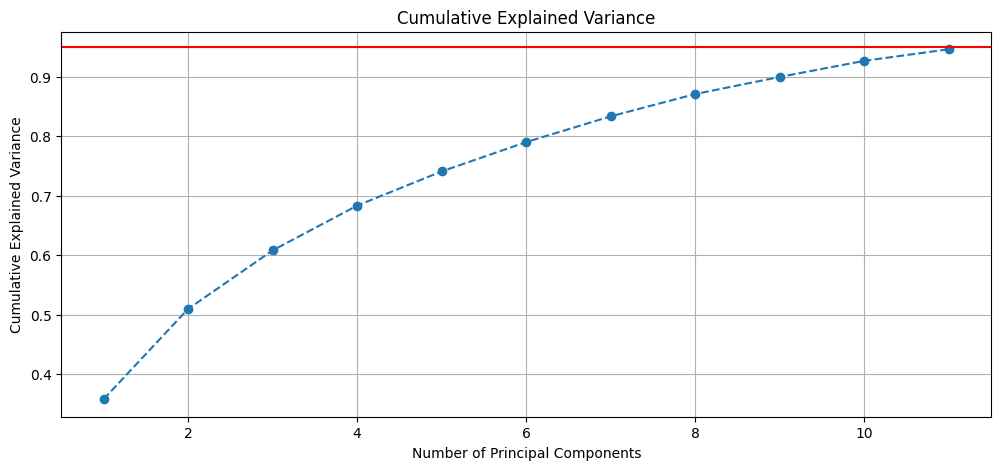

In [26]:
# Select only the ordinal variables
df_ordinal = nj_hvi_num[['P_PM25', 'P_ASTHMA', 'P_COPD', 'P_DIABETES',
       'ICR', 'P_OZONE', 'P_POV', 'P_ELP', 'P_UNINSUR', 'P_AGE65',
       'P_AGE5', 'P_DISABL', 'P_ISO', 'P_UNEMP', 'P_NOHSDP']]

# Standardize the ordinal variables
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_ordinal)

cov_matrix = np.cov(df_scaled.T)  # Compute covariance matrix of transposed data
print("Covariance Matrix Shape:", cov_matrix.shape)
# Perform PCA, keeping the top 5 principal components
pca = PCA(n_components=11)
principal_components = pca.fit_transform(df_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(11)])

# Explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [27]:
feature_importance = pd.DataFrame(pca.components_, columns=df_ordinal.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])
reduced_data = feature_importance.T[[f'PC{i+1}' for i in range(11)]]

In [28]:
X = nj_hvi_num[['P_PM25', 'P_ASTHMA', 'P_COPD', 'P_DIABETES',
       'ICR', 'P_OZONE', 'P_POV', 'P_ELP', 'P_UNINSUR', 'P_AGE65',
       'P_AGE5', 'P_DISABL', 'P_ISO', 'P_UNEMP', 'P_NOHSDP']]
y = nj_hvi_num['HVI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train_pca, y_train)
y_pred = xgb_reg.predict(X_test_pca)
# Round predictions to the nearest integer and clip to ensure they remain between 1 and 5
y_pred_ordinal = np.clip(np.round(y_pred), 1, 5).astype(int)
non_clipped_pred = np.round(y_pred)

In [29]:
X_train_pca.shape, X_test_pca.shape

((1454, 11), (364, 11))

In [30]:
# Calculate Mean Absolute Error (MAE) and display a classification report
mae = mean_absolute_error(y_test, y_pred_ordinal)
non_clipped_mae = mean_absolute_error(y_test, non_clipped_pred)
print("Mean Absolute Error:", mae)
print("Non-Clipped Mean Absolute Error:", non_clipped_mae)

# Krippendorff's Alpha for ordinal evaluation
ratings = np.array([y_test, y_pred_ordinal])
non_clipped_ratings = np.array([y_test, non_clipped_pred])
pred_vs_real = pd.DataFrame(np.array([y_test, y_pred, y_pred_ordinal, non_clipped_pred]).T, columns=["True", "y_pred", "y_pred_ordinal", "non_clipped_pred"])

print("Krippendorff's alpha: ", krippendorff.alpha(reliability_data=ratings, level_of_measurement="ordinal"))
print("Non-Clipped Krippendorff's alpha: ", krippendorff.alpha(reliability_data=non_clipped_ratings, level_of_measurement="ordinal"))

qwk = cohen_kappa_score(y_test, y_pred_ordinal, weights="quadratic")
non_clipped_qwk = cohen_kappa_score(y_test, non_clipped_pred, weights="quadratic")
print(f"Quadratic Weighted Kappa: {qwk}")
print(f"Non-Clipped Quadratic Weighted Kappa: {non_clipped_qwk}")

pred_vs_real

Mean Absolute Error: 0.2692307692307692
Non-Clipped Mean Absolute Error: 0.2692307692307692
Krippendorff's alpha:  0.9307599264077981
Non-Clipped Krippendorff's alpha:  0.9307599264077981
Quadratic Weighted Kappa: 0.9302957234026754
Non-Clipped Quadratic Weighted Kappa: 0.9302957234026754


,True,y_pred,y_pred_ordinal,non_clipped_pred
0,1.0,1.086272,1.0,1.0
1,5.0,4.929364,5.0,5.0
2,1.0,1.587125,2.0,2.0
3,3.0,3.472605,3.0,3.0
4,2.0,1.911707,2.0,2.0
...,...,...,...,...
359,4.0,4.066529,4.0,4.0
360,5.0,4.554809,5.0,5.0
361,3.0,2.980023,3.0,3.0
362,5.0,4.253280,4.0,4.0


### Semi-supervised ordinal regression with HHI data

In [31]:
pred_df = pred_df.replace([np.inf, -np.inf], np.nan)
pred_df = pred_df.dropna(subset=["ICR"], how="all")
pred_df

,P_PM25,P_ASTHMA,P_COPD,P_DIABETES,ICR,P_OZONE,P_POV,P_ELP,P_UNINSUR,P_AGE65,P_AGE5,P_DISABL,P_ISO,P_UNEMP,P_NOHSDP
0,0.000000,9.0,5.3,10.6,3.492341,1.666667,16.990921,4.517345,7.3,10.9,5.6,9.3,12.967654,5.4,7.7
1,0.000000,9.8,6.1,10.3,20.927346,1.666667,23.700924,7.182714,9.8,14.2,7.2,10.6,15.901331,6.0,11.4
2,0.333333,9.3,4.8,8.7,2.204795,1.666667,15.112355,5.205557,8.8,13.4,6.3,9.2,15.531732,6.7,8.1
3,0.333333,8.6,5.2,7.8,0.490865,1.333333,1.799729,1.918977,2.6,27.9,4.8,10.9,7.343670,2.1,6.1
4,0.333333,8.9,5.1,8.5,0.095384,1.000000,11.319473,3.168692,4.4,15.4,4.7,8.0,11.196106,5.1,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,10.333333,9.2,4.6,7.1,0.058518,7.666667,8.908297,0.000000,11.2,12.3,5.0,11.0,15.287958,1.6,4.2
3294,9.333333,9.4,5.2,8.4,0.316049,5.000000,34.827586,11.754069,10.5,9.8,4.7,15.5,16.772824,0.0,17.4
3295,10.333333,9.9,5.6,8.7,0.107231,6.000000,20.783663,5.175707,9.6,15.4,5.4,14.7,16.355865,6.7,10.5
3296,11.666667,9.4,4.4,7.0,0.079267,9.000000,13.062527,1.528670,7.0,14.1,4.8,7.9,9.338220,2.0,4.9


In [32]:
df_ordinal

,P_PM25,P_ASTHMA,P_COPD,P_DIABETES,ICR,P_OZONE,P_POV,P_ELP,P_UNINSUR,P_AGE65,P_AGE5,P_DISABL,P_ISO,P_UNEMP,P_NOHSDP
0,2,3,1,1,1,2,1,1,3,3,2,2,1,2,1
1,2,3,3,2,2,2,4,3,4,2,3,2,3,4,3
2,2,5,3,5,5,2,5,5,5,1,5,1,1,4,5
3,2,3,5,3,1,2,2,2,3,5,4,1,5,1,2
4,2,2,3,2,2,2,1,3,1,4,5,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,1,4,2,2,3,3,4,4,2,2,4,5,3,4,4
1814,1,3,5,5,3,3,4,2,1,5,1,3,5,3,3
1815,5,4,4,3,3,5,1,1,3,4,1,3,4,4,2
1816,5,2,4,2,2,5,1,1,2,5,1,2,3,3,2


Covariance Matrix Shape: (15, 15)
Explained Variance Ratio: [0.26600629 0.19360345 0.09947039 0.06914849 0.06508053 0.05801554
 0.05135817 0.04844915 0.03927011 0.03042301 0.02808799]


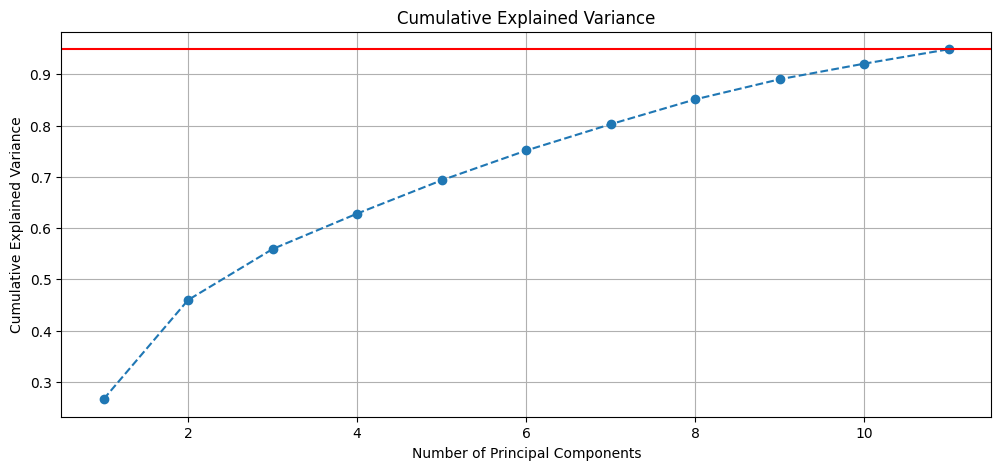

In [33]:
scaler = StandardScaler()
pred_df = scaler.fit_transform(pred_df)

cov_matrix = np.cov(pred_df.T)  # Compute covariance matrix of transposed data
print("Covariance Matrix Shape:", cov_matrix.shape)
# Perform PCA, keeping the top 5 principal components
pca = PCA(n_components=11)
principal_components_hhi = pca.fit_transform(pred_df)

# Convert to DataFrame
pca_df_hhi = pd.DataFrame(principal_components_hhi, columns=[f'PC{i+1}' for i in range(11)])

# Explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [34]:
X_test_hhi = pca.transform(pred_df)
perturbed_X_test = X_test_hhi + np.random.normal(0, 0.01, X_test_hhi.shape)
y_pred = xgb_reg.predict(X_test_hhi)
y_pred_perturbed = xgb_reg.predict(perturbed_X_test)
y_pred_ordinal = np.clip(np.round(y_pred), 1, 5).astype(int)
y_pred_ordinal_perturbed = np.clip(np.round(y_pred), 1, 5).astype(int)

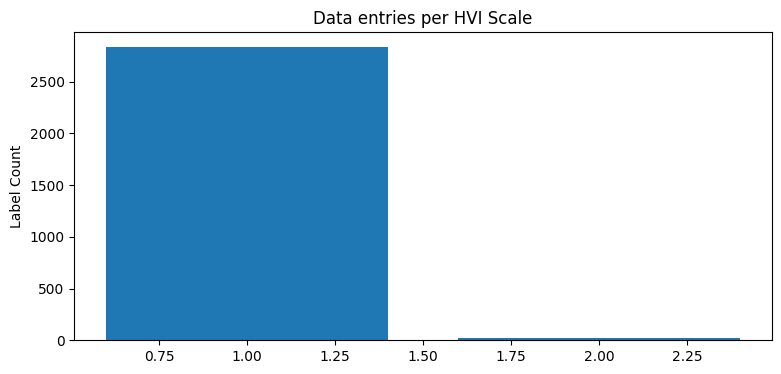

In [ ]:
comparison = np.array([y_pred_ordinal, y_pred_ordinal_perturbed])
comparison_df = pd.DataFrame(np.array([y_pred_ordinal, y_pred_ordinal_perturbed]).T, columns=["y_pred_ordinal", "y_pred_ordinal_perturbed"])
comparison_count = comparison_df["y_pred_ordinal"].value_counts().reset_index()
fig, ax = plt.subplots()

fig.set_size_inches(9, 4)
labels = comparison_count['index']
counts = comparison_count["y_pred_ordinal"]

ax.bar(labels, counts)

ax.set_ylabel('Label Count')
ax.set_title('Data entries per HVI Scale')

plt.show()

### Regression with Composite HVI data

In [56]:
# Optimal cluster with elbow method
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from kneed import KneeLocator

### Clustering with unlabelled data

##### K-means Clustering with Average of percentile score for each category

In [46]:
# clustering_data["STATEFP10"] = clustering_data["STATEFP10"].apply(lambda x: "FL" if x == 12)
clustering_data["STATEFP10"] = clustering_data["STATEFP10"].apply(lambda x: "NJ" if x == 34 else ("CA" if x == 6 else ("FL" if x == 12 else "Other")))
clustering_data.head()

,STATEFP10,POP,HHB_SCORE,SEN_SCORE,SOCIODEM_SCORE,NBE_SCORE
0,NJ,16305,0.2435,0.0,0.4302,0.6330
1,NJ,63031,0.5618,0.0,0.5651,0.6743
2,NJ,47312,0.5572,0.0,0.4925,0.6568
3,NJ,7440,0.3332,0.0,0.3256,0.4432
4,NJ,15269,0.4934,0.0,0.3459,0.4722


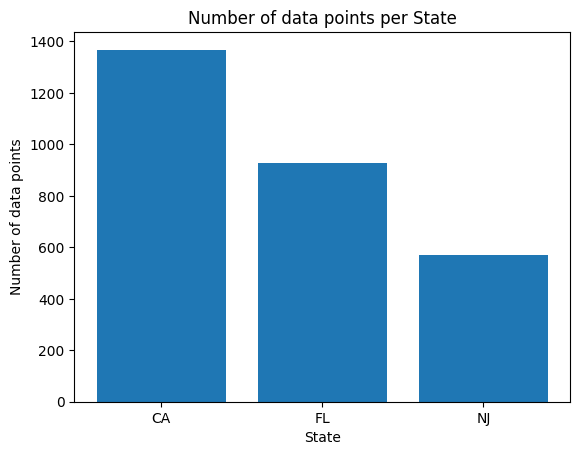

In [47]:
plt.bar(clustering_data["STATEFP10"].value_counts().index, clustering_data["STATEFP10"].value_counts().values)
plt.title("Number of data points per State")
plt.xlabel("State")
plt.ylabel("Number of data points")
plt.show()

Optimal k for State NJ: 5
Optimal k for State FL: 5
Optimal k for State CA: 5


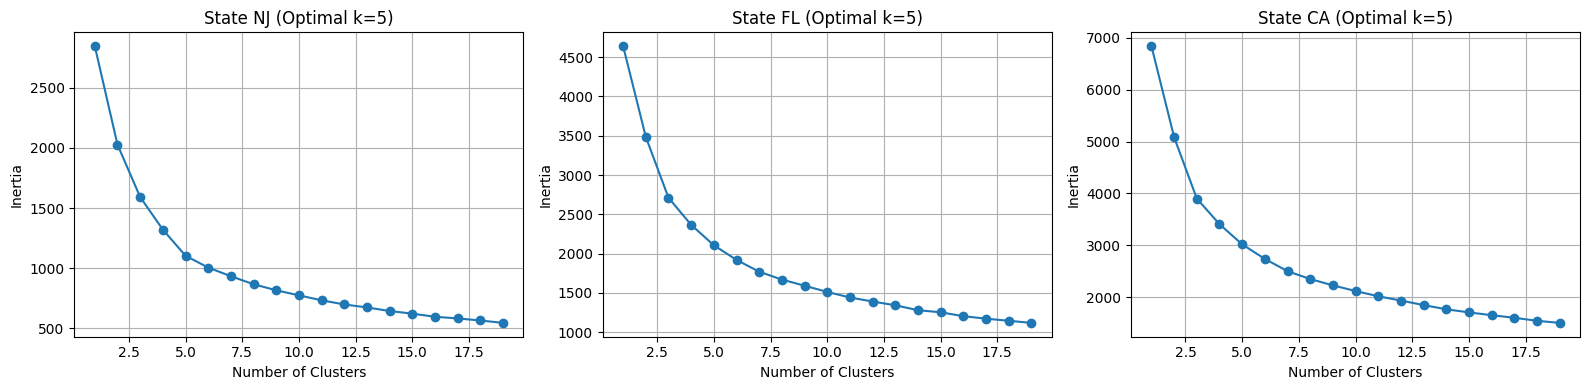

In [ ]:
K = 20
scaler = StandardScaler()
states = clustering_data["STATEFP10"].unique()

# Create subplots dynamically based on the number of states
num_states = len(states)
cols = 3  # Number of columns for the subplots
rows = int(np.ceil(num_states / cols))  # Compute required rows

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()  # Flatten in case we have fewer states

for i, state in enumerate(states):
    state_data = clustering_data[clustering_data["STATEFP10"] == state]
    state_data_scaled = scaler.fit_transform(state_data.drop("STATEFP10", axis=1))

    inertia = []
    inertia_mapper = {}
    for k in range(1, K):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(state_data_scaled)
        inertia.append(kmeans.inertia_)
        inertia_mapper[k] = kmeans.inertia_

    kneedle = KneeLocator(list(inertia_mapper.keys()), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow
    print(f"Optimal k for State {state}: {optimal_k}")

    # Plot on corresponding subplot
    axes[i].plot(range(1, K), inertia, marker='o', linestyle='-')
    axes[i].set_title(f"State {state} (Optimal k={optimal_k})")
    axes[i].set_xlabel("Number of Clusters")
    axes[i].set_ylabel("Inertia")
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


0    440
1    620
2    625
3    403
4    777
Name: Cluster, dtype: int64


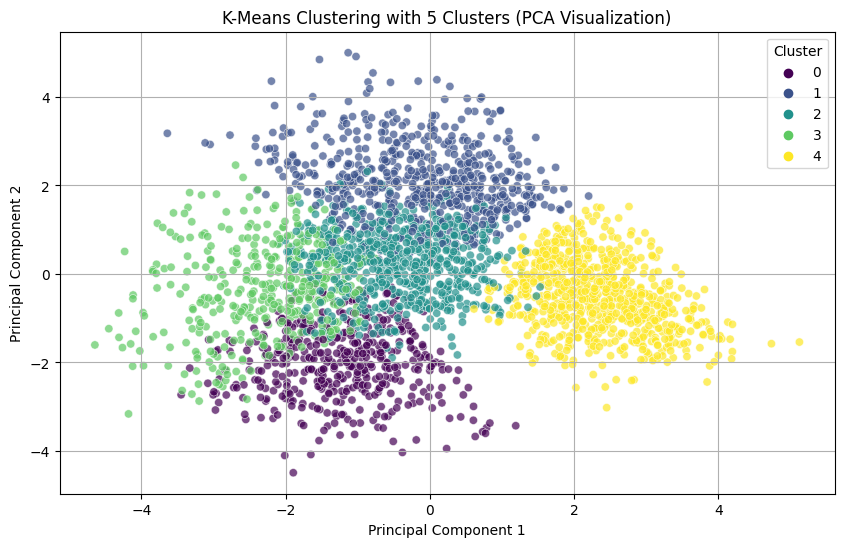

In [70]:
# Define the number of clusters
num_clusters = 5

# Standardize the data (excluding the 'STATEFP10' column)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(clustering_data.drop("STATEFP10", axis=1))

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clustering_data["Cluster"] = kmeans.fit_predict(data_scaled)

# Display cluster counts
print(clustering_data["Cluster"].value_counts().sort_index())

# dimensionality reduction for visualization
pca = PCA(n_components=2)  # Reduce to 2D for visualization
pca_data = pca.fit_transform(data_scaled)

# Create a DataFrame with PCA results
clustering_data["PCA1"] = pca_data[:, 0]
clustering_data["PCA2"] = pca_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=clustering_data, palette="viridis", alpha=0.7)
plt.title("K-Means Clustering with 5 Clusters (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
